### imports

In [40]:
import pomegranate.io
from pomegranate import *

In [41]:
import json
import numpy as np
import pandas as pd


In [42]:
from networkx import all_simple_paths
from tqdm import tqdm
from collections import defaultdict
from itertools import islice

In [43]:
import sys
PATH_TO_PREDICTOR_HOME = "../.."
sys.path.append(PATH_TO_PREDICTOR_HOME)
METHOD = "hmm_pomegranate"

In [44]:
from copy import deepcopy
from peptides_utils import split_to_dicts, join_dicts, get_frequencies

In [45]:
from hmm_visualization_methods import *
from training_parameters import *

In [46]:
from data_reading_methods import *

In [47]:
import training_parameters
from peptides_utils import defineClass, defineOrganism, make_logo_for_data
from data_reading_methods import remove_unused_lengths, transform_data_to_properties_and_join_alleles, calculate_weights_based_on_length_counts

In [48]:

import logomaker
from collections import deque
import sys
import matplotlib.pyplot as plt
from scipy.spatial.distance import jensenshannon

# rewrited functions

#### data_funcs

type_of_peptides parameter was added to make it possible to work (read and prepare for thraining models) not only with binders, but also with n0n-binders

In [49]:
def get_train_test_data(experiment_params :ExperimentParams, type_of_peptides= "binders"):
    data_params : DataScenarioParams = experiment_params.data_scenario_params
    data_scenario = data_params.data_scenario
    DATA_PATH = data_params.input_data_path
    TOTAL_SPLITS = data_params.splits_to_read
    print(f"Will read files from the folder {DATA_PATH}")
    assert data_scenario in ["IEDB_preprocessed", "simulated", "simulated_preprocessed", 'MixMHCpred']
    additional_return = list()
    if isinstance(data_params, PreprocessedIEDBDataParams):
        ALLELES = get_available_alleles(DATA_PATH)
        per_allele_per_kfold_per_length_binders_train = read_data(DATA_PATH,ALLELES, "train", type_of_peptides)
        per_allele_per_kfold_per_length_binders_test = read_data(DATA_PATH,ALLELES, "test", type_of_peptides)
        sample_allele = list(per_allele_per_kfold_per_length_binders_train.keys())[0]
        per_allele_df = join_dicts(per_allele_per_kfold_per_length_binders_train)
        for allele_name in ALLELES:
            per_allele_df[allele_name]['allele'] = allele_name
        assert len(per_allele_per_kfold_per_length_binders_train[sample_allele].keys()) >= TOTAL_SPLITS # check number of splits
        additional_return.append(per_allele_df)
    elif isinstance(data_params, SimulatedPreprocessedDataParams):
        ALLELES = get_available_alleles(DATA_PATH, do_not_parse_alleles=True)
        per_allele_per_kfold_per_length_binders_train = read_data(DATA_PATH,ALLELES, "train", type_of_peptides, do_not_parse_alleles=True)
        per_allele_per_kfold_per_length_binders_test = read_data(DATA_PATH,ALLELES, "test", type_of_peptides,do_not_parse_alleles=True)
        sample_allele = list(per_allele_per_kfold_per_length_binders_train.keys())[0]
        per_allele_df = join_dicts(per_allele_per_kfold_per_length_binders_train)
        for allele_name in ALLELES:
            per_allele_df[allele_name]['allele'] = allele_name
        assert len(per_allele_per_kfold_per_length_binders_train[sample_allele].keys()) >= TOTAL_SPLITS # check number of splits
        additional_return.append(per_allele_df)
    elif isinstance(data_params, SimulatedDataParams):
        simulated_exact_file = data_params.simulated_exact_file_name
        dummy_allele_name = data_params.dummy_allele_name
        simulated_scenario = data_params.simulated_scenario
        SIMULATED_DATA_PATH = f"{DATA_PATH}/{simulated_scenario}/{simulated_exact_file}"
        ALLELES = [dummy_allele_name]
        per_allele_df = dict()
        # For now just read the same data multiple times for alleles/splits
        for allele_name in ALLELES:
            allele_df = pd.read_csv(SIMULATED_DATA_PATH, sep=";")
            list_dfs = [allele_df.copy() for i in range(TOTAL_SPLITS)]
            for split_num, split_df in enumerate(list_dfs):
                split_df['split'] = split_num
                split_df['allele_name'] = allele_name
                result_allele_df = pd.concat(list_dfs)
            per_allele_df[allele_name] = result_allele_df
            result_allele_df['length'] = split_df.peptide.str.len()
            TARGET_LENGTHS = list(split_df['length'].unique())
        # split data into dicts
        per_allele_per_kfold_per_length_binders_train = split_to_dicts(per_allele_df,
                                                                  ALLELES=ALLELES,
                                                                  TARGET_LENGTHS=TARGET_LENGTHS,
                                                                  TOTAL_SPLITS=np.arange(TOTAL_SPLITS))
        per_allele_per_kfold_per_length_binders_test =  split_to_dicts(per_allele_df,
                                                                  ALLELES=ALLELES,
                                                                  TARGET_LENGTHS=TARGET_LENGTHS,
                                                                  TOTAL_SPLITS=np.arange(TOTAL_SPLITS))
        additional_return.append(per_allele_df)
    elif isinstance(data_params, MixMHCpredDataParams):
        mixture_name = data_params.mixmhc_mixture_name
        dummy_allele_name = data_params.dummy_allele_name
        df = pd.read_csv(DATA_PATH, sep=';')
        print(df.columns)
        df = df.loc[
            df.Peptide.str.match("^[ACDEFGHIKLMNPQRSTVWY]+$")
        ]
        print("Total table length", len(df))
        #Filter out selected mixture
        df = df.loc[df.Sample_IDs.str.split(', ').apply(lambda x: mixture_name in x),]
        print("Filtered for given mixture", len(df))
        sample_data = pd.DataFrame(
            {"peptide": df.Peptide.values,
             "old_sample_id": df.Sample_IDs,
             "sample_id": mixture_name,
             "mixmhc_predicted_mixed_alleles": df.Allele.values})

        list_dfs = [sample_data.copy() for i in range(TOTAL_SPLITS)]
        per_allele_df = dict()
        allele_name = "d_" + dummy_allele_name
        ALLELES = [allele_name]
        for allele_name in ALLELES:
            for split_num, split_df in enumerate(list_dfs):
                split_df['split'] = split_num
                split_df['allele'] = allele_name
                split_df['length'] = split_df.peptide.str.len()
            result_allele_df = pd.concat(list_dfs)
            result_allele_df = result_allele_df.drop_duplicates(subset=['peptide'])
            TARGET_LENGTHS = list(split_df['length'].unique())
            per_allele_df[allele_name] = result_allele_df
        per_allele_per_kfold_per_length_binders_train = split_to_dicts(per_allele_df,
                                                                  ALLELES=ALLELES,
                                                                  TARGET_LENGTHS=TARGET_LENGTHS,
                                                                  TOTAL_SPLITS=np.arange(TOTAL_SPLITS))
        per_allele_per_kfold_per_length_binders_test = split_to_dicts(per_allele_df,
                                                                  ALLELES=ALLELES,
                                                                  TARGET_LENGTHS=TARGET_LENGTHS,
                                                                  TOTAL_SPLITS=np.arange(TOTAL_SPLITS))
        additional_return.append(per_allele_df)
        additional_return.append(df)
    return per_allele_per_kfold_per_length_binders_train,  per_allele_per_kfold_per_length_binders_test, additional_return

from pomegranate.io import BatchedDataGenerator, SequenceGenerator
def create_char_arrays(peptide_sequences):
    return np.array([[char for char in peptide] for peptide in peptide_sequences], dtype=object)

def prepare_split_data_separeted_length(per_length_data, per_length_weights, per_length_test_data, target_lengths):
    binders_array = np.array([per_length_data[length][i] for length in target_lengths
                              for i in range(len(per_length_data[length]))], dtype=object)
    weights_array = np.array([per_length_weights[length][i] for length in target_lengths
                               for i in range(len(per_length_weights[length]))], dtype=object)
    binders_test_array = np.array([per_length_test_data[length][i] for length in target_lengths
                                   for i in range(len(per_length_test_data[length]))], dtype=object)
    return binders_array, weights_array, binders_test_array

####  logic functions

**Logic** – Implements custom HMM training and inference procedures, modifying pomegranate’s original functions to support multiple splits (e.g., cross-validation) with configurable run counts per split. Additionally, the rewritten functions allow single-run execution, simplifying the structure when only one iteration is needed. This makes the logic more adaptable to different experimental setups.

train_single_model - for training 1 model (only model itselof withoun runs or splits)

In [50]:
from IPython.display import HTML

In [51]:
html_code = """
<div style="text-align: left; margin-left: 0; width: fit-content;">
<!DOCTYPE html>
<html>
<head>
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <style>
        body {
            font-family: -apple-system, sans-serif;
            line-height: 1.5;
            max-width: 600px;
            margin: 0;
            padding: 20px 20px 20px 0;
            color: #333;
            text-align: left;
        }
        h1 {
            font-weight: 500;
            text-align: left;
            margin-bottom: 30px;
        }
        .flow-step {
            margin-bottom: 0;  /* Reduced space between steps */
            padding-bottom: 0;
            text-align: left;
        }
        .func-name {
            font-weight: 500;
            color: #0066cc;
            text-align: left;
        }
        .dict {
            font-family: monospace;
            background: #f8f8f8;
            padding: 10px;
            border-radius: 4px;
            overflow-x: auto;
            font-size: 14px;
            margin: 10px 0;
            text-align: left;
            width: fit-content;
        }
        .arrow-wrapper {
            display: flex;
            justify-content: center;
            width: 100%;
            margin: 5px 0;
        }
        .arrow {
            color: #999;
            text-align: center;
            width: 20px;
        }
    </style>
</head>
<body>
    <h1>Model Preparation Flow</h1>

    <div class="flow-step">
        <div class="func-name">prepare_multiple_models()</div>
        Creates this nested dictionary structure:
        <div class="dict">{
  "HLA-A*02:01": {0: {}, 1: {}}, 
  "HLA-B*07:02": {0: {}, 1: {}}
}</div>
    </div>
    <div class="arrow-wrapper">
        <div class="arrow">↓</div>
    </div>

    <div class="flow-step">
        <div class="func-name">make_models_for_runs()</div>
        Fills each split with run models:
        <div class="dict">{
  "root[0000]": Model,
  "root[0001]": Model,
  ...
}</div>
    </div>
    <div class="arrow-wrapper">
        <div class="arrow">↓</div>
    </div>

    <div class="flow-step">
        <div class="func-name">build_model_based_on_params()</div>
        Creates each model with unique name:
        <div class="dict">Model {
  name: "root[0000]_run-params-0"
}</div>
    </div>
</body>
</html>
</div>
"""

HTML(html_code)

In [52]:

def make_models_for_runs(allele_name, experiment_params: ExperimentParams, split_num = 1, custom_models_id: str = "root"):
    model_training_params = experiment_params.model_training_params
    original_num_runs = model_training_params.num_runs
    total_runs = original_num_runs * model_training_params.decrease_anchor_aas_steps
    

    target_allele_name = allele_name.replace('-', '_').replace('*', '_').replace(':', '_').replace('/', '_')
    models_for_runs = {}
    
    for run_num in range(total_runs):
        run_index = f"{custom_models_id}[{run_num:04d}]"
        acids_to_subtract = run_num // original_num_runs
        current_params = deepcopy(model_training_params)
        current_params.anchor_top_aas -= acids_to_subtract
        
        prepared_model = build_model_based_on_params(current_params)
        prepared_model.name = (
            f'{run_index}_run-{current_params.get_model_common_names()}_model-{target_allele_name}-{split_num}'
        )
        
        models_for_runs[run_index] = prepared_model
    
    return models_for_runs

def prepare_multiple_models(experiment_params: ExperimentParams):
    data_scenario_params = experiment_params.data_scenario_params
    model_training_params = experiment_params.model_training_params
    alleles_to_use = model_training_params.alleles_to_use

    per_allele_per_split_prepared_models = {}
    
    for allele_name in alleles_to_use:
        per_allele_per_split_prepared_models[allele_name] = {}
        
        for split_num in range(data_scenario_params.splits_to_read):
            per_allele_per_split_prepared_models[allele_name][split_num] = make_models_for_runs(
                allele_name, experiment_params, split_num
            )
    
    return per_allele_per_split_prepared_models

Functions for work with strings of peptides to fit the model

In [53]:

def create_char_arrays(peptide_sequences):
    return np.array([[char for char in peptide] for peptide in peptide_sequences], dtype=object)

def prepare_split_data_separeted_length(per_length_data, per_length_weights, per_length_test_data, target_lengths):
    binders_array = np.array([per_length_data[length][i] for length in target_lengths
                              for i in range(len(per_length_data[length]))], dtype=object)
    weights_array = np.array([per_length_weights[length][i] for length in target_lengths
                               for i in range(len(per_length_weights[length]))], dtype=object)
    binders_test_array = np.array([per_length_test_data[length][i] for length in target_lengths
                                   for i in range(len(per_length_test_data[length]))], dtype=object)
    return binders_array, weights_array, binders_test_array

def process_split_data(per_length_data, per_length_weights, per_length_test_data, target_lengths):
    """Prepare and shuffle data arrays."""
    binders_array, weights_array, binders_test_array = prepare_split_data_separeted_length(per_length_data, per_length_weights, per_length_test_data, target_lengths)
    rng = np.random.default_rng()
    new_indexes = rng.permutation(len(binders_array))
    binders_array = binders_array[new_indexes]
    weights_array = weights_array[new_indexes]
    rng.shuffle(binders_test_array)
    sample_X = create_char_arrays(binders_array)
    sample_X_test = create_char_arrays(binders_test_array)
    return sample_X, sample_X_test, weights_array

Training functions 

In [54]:
html_code_training = """
<div style="text-align: left; margin-left: 0; width: fit-content;">
<!DOCTYPE html>
<html>
<head>
    <meta name="viewport" content="width=device-width, initial-scale=1">
    <style>
        body {
            font-family: -apple-system, sans-serif;
            line-height: 1.5;
            max-width: 600px;
            margin: 0;
            padding: 20px 20px 20px 0;
            color: #333;
            text-align: left;
        }
        h1 {
            font-weight: 500;
            text-align: left;
            margin-bottom: 30px;
        }
        .flow-step {
            margin-bottom: 0;
            padding-bottom: 0;
            text-align: left;
            position: relative;
        }
        .func-name {
            font-weight: 500;
            text-align: left;
        }
        .active-func {
            color: #0066cc;
            background-color: #e8f4fc;
            padding: 8px;
            border-radius: 4px;
        }
        .inactive-func {
            color: #888;
        }
        .dict {
            font-family: monospace;
            background: #f8f8f8;
            padding: 10px;
            border-radius: 4px;
            overflow-x: auto;
            font-size: 14px;
            margin: 10px 0;
            text-align: left;
            width: fit-content;
        }
        .arrow-down {
            display: flex;
            justify-content: center;
            width: 100%;
            margin: 5px 0;
            color: #999;
        }
        .param-list {
            font-size: 13px;
            color: #666;
            margin-top: 5px;
        }
        .scope-indicator {
            font-size: 12px;
            color: #0066cc;
            margin-top: 5px;
            font-style: italic;
        }
    </style>
</head>
<body>
    <h1>Complete Training Flow</h1>

    <div class="flow-step">
        <div class="func-name active-func">train_single_model()</div>
        <div class="param-list">Parameters: model, sample_X, sample_X_test, weights_array, model_training_params</div>
        <div class="dict">Returns: model, history</div>
    </div>

    <div class="arrow-down">↓</div>

    <div class="flow-step">
        <div class="func-name active-func">train_models_for_runs()</div>
        <div class="param-list">Parameters: prepared_models, train_data, test_data, weights, params, save_path</div>
        <div class="dict">Returns: {
  "run_0001": (model, history),
  "run_0002": (model, history)
}</div>
        <div class="scope-indicator">(This notebook stops here)</div>
    </div>

    <div class="arrow-down">↓</div>

    <div class="flow-step">
        <div class="func-name inactive-func">train_models_for_splits()</div>
        <div class="param-list">Parameters: prepared_models, train_data, test_data, weights, params, experiment_params, save_path</div>
        <div class="dict">Returns: {
  "split_0": {"run_0001": model, ...},
  "split_1": {"run_0001": model, ...}
}</div>
    </div>

    <div class="arrow-down">↓</div>

    <div class="flow-step">
        <div class="func-name inactive-func">train_models_for_alleles()</div>
        <div class="param-list">Parameters: prepared_models, train_data, test_data, weights, experiment_params, save_path</div>
        <div class="dict">Returns: {
  "HLA_A_01_01": {"split_0": {...}, ...},
  "HLA_B_07_02": {"split_0": {...}, ...}
}</div>
    </div>
</body>
</html>
</div>
"""

In [55]:
HTML(html_code_training)

In [56]:
def train_single_model( model, sample_X, sample_X_test, weights_array, model_training_params):
    """Fit a single model for a given split."""
    verbose = model_training_params.verbose
    multiple_check_input = model_training_params.multiple_check_inpit
    algorithm = model_training_params.algorithm
    lr_decay = model_training_params.lr_decay
    minibatch_training = model_training_params.minibatch_training
    batches_per_epoch = model_training_params.batches_per_epoch
    batch_size = model_training_params.batch_size
    min_iterations = model_training_params.min_iters
    max_iterations = model_training_params.maxiters
    emission_pseudocount = model_training_params.emission_pseudocount
    transition_pseudocount = model_training_params.transition_pseudocount
    use_pseudocount = model_training_params.use_pseudocounts
    edge_inertia = model_training_params.edge_inertia
    distribution_inertia = model_training_params.distribution_inertia
    stop_threshold = model_training_params.stop_threshold
    n_jobs = 1  # Modify if needed
    
    sequence_test_generator = SequenceGenerator(sample_X_test)
    
    if minibatch_training:
        sequence_generator = BatchedDataGenerator(sample_X,
                                                  batches_per_epoch=batches_per_epoch,
                                                  batch_size=batch_size)
        sequence_generator.reset()
    else:
        sequence_generator = sample_X
    
    model, history = model.fit(sequence_generator,
                               sequences_test=sequence_test_generator,
                               stop_threshold=stop_threshold,
                               return_history=True,
                               verbose=verbose,
                               multiple_check_input=multiple_check_input,
                               n_jobs=n_jobs,
                               algorithm=algorithm,
                               lr_decay=lr_decay,
                               distribution_inertia=distribution_inertia,
                               edge_inertia=edge_inertia,
                               batches_per_epoch=batches_per_epoch,
                               min_iterations=min_iterations,
                               max_iterations=max_iterations,
                               emission_pseudocount=emission_pseudocount,
                               transition_pseudocount=transition_pseudocount,
                               use_pseudocount=use_pseudocount,
                               weights=weights_array)
    
    return model, history


In [57]:
def train_models_for_runs(prepared_models, train_data, test_data, train_data_weights, model_training_params, path_to_save_models):
    """
    Train models for different runs within a single split.
    """
    result_models = {}
    result_histories = {}
    target_lengths = model_training_params.lengths_to_use

    per_run_models = dict()
    per_run_histories = dict()
    
    for run_index, model in prepared_models.items():
        print(f"Run {run_index}", end=" ")
        if model and run_index in prepared_models:
            sample_X, sample_X_test, weights_array = process_split_data(train_data, train_data_weights, test_data, target_lengths)
            model, history = train_single_model(model, sample_X, sample_X_test, weights_array, model_training_params)
            per_run_models[run_index] = model
            per_run_histories[run_index] = history
            
            path_to_save_models_runs = path_to_save_models 
            save_model(path_to_save_models_runs, model, history)
        else:
            print(f"Skipping training for split {run_index}, model not provided.")
            break
    
    print(" ")
    return per_run_models, per_run_histories

In [58]:
def reorder_per_run_models_by_score(run_models, run_histories, path):
    # Create a DataFrame with models and their log probabilities
    df = pd.DataFrame({
        "model": list(run_models.keys()),
        "log_probability": [run_histories[run].log_probabilities[-1] for run in run_models.keys()]
    })
    
    # Sort the DataFrame by 'log_probability'
    sorted_df = df.sort_values(by='log_probability', ascending=False).reset_index(drop=True)

    # Create a dictionary to map "run new" to "run old" (the original order)
    run_mapping = {sorted_df['model'].iloc[i]: list(run_models.keys())[i] for i in range(len(sorted_df))}
    sorted_histories = {f"run[{i:04d}]": run_histories[sorted_df['model'].iloc[i]] for i in range(len(sorted_df))}


    # Generate per_run_models with formatted run indices
    per_run_models = {f"run[{i:04d}]": run_models[sorted_df['model'].iloc[i]] for i in range(len(sorted_df))}

    for run_ind, models in per_run_models.items():
        original_model_name = models.name
        rest_part = "_".join(original_model_name.split("_"))
        #print(rest_part)
        print(f"Run {run_ind}", end=" ")
        # Update the model name with the new formatted index
        #new_name = f"run[{run_ind:04d}_{rest_part}"
        new_name = f"{run_ind}_{rest_part}"
        models.name = new_name
        
        # Get the original run key from sorted_df
        run_key = sorted_df['model'].iloc[int(run_ind[4:-1])]  # Extract the numeric part from 'run[0000]'
        save_model(path + '//', models, run_histories[run_key])

    return per_run_models, sorted_histories, run_mapping


#### Visualisation

Functions for visualization after training (learning curve, plot with model archetecture and distributions of amino acids in each state)

In [59]:
def make_pyviz_graph(model, TARGET_PATH_TO_RESULTS, precision=4, prefefined_hierarchical_layout=True):
    graph, name_to_level = convert_graph_to_good_format(model, f"{model.name}/", precision=precision)
                                                      # f"{os.getcwd()}/{TARGET_PATH_TO_RESULTS}/{model.name}/")

    nt = Network('500px', '1600', directed=True)
    if pyvis._version.__version__ > '0.1.9':
        #Bug in pyvis
        nt.from_nx(graph, show_edge_weights=True)
    else:
        nt.from_nx(graph)
    #nt.show_buttons()
    #nt.show_buttons(filter_=['physics'])
    if prefefined_hierarchical_layout:
        nt.set_options(
    """
    var options = {
        "configure": {
        "enabled": true
    },
      "layout": {
        "hierarchical": {
          "enabled": true,
          "direction": "LR"
        }
      },
      "physics": {
        "hierarchicalRepulsion": {
          "centralGravity": 0
        },
        "minVelocity": 0.75,
        "solver": "hierarchicalRepulsion"
      }
    }
    """)
    else:
        nt.show_buttons()


    path_to_save_html = f"{TARGET_PATH_TO_RESULTS}"
    if not os.path.exists(path_to_save_html):
        os.makedirs(path_to_save_html)


    nt.save_graph(f"{path_to_save_html}/{model.name}.html")
    # nt.show(f"{TARGET_PATH_TO_RESULTS}\\{model.name}\\pyviz.html")
    return nt

In [60]:
def save_visualizations_for_model(model, history, split_path, experiment_params, predefined_hierarchical_layout):
    """
    Saves various visualizations for a given model, including the learning curve,
    state graph, distributions, and PyViz graph.
    """
    path_for_model = f"{split_path}/{model.name}/"
    if not os.path.exists(path_for_model):
        os.makedirs(path_for_model)
    

    # Learning Curve
    path_to_save_learning_curve = path_for_model + "LearningCurve"
    fig, ax = plt.subplots(1, 1)
    sns.lineplot(history.log_probabilities, ax=ax)
    plt.savefig(path_to_save_learning_curve)
    plt.close(fig)

    # State Graph
    #print('\nModelGraph')
    path_to_save_ModelGraph = path_for_model + "ModelGraph.png"

    with open(path_to_save_ModelGraph, 'w+') as f:
        model.plot(file=f, crop_zero=True)

    # Distributions
    #print('\nDistributions')
    plot_distributions_for_states(model, split_path, horizontal=False,
                                  discrete=experiment_params.model_training_params.aa_labels_training,
                                  initial_params=experiment_params.model_training_params.initial_params)

    # PyViz Graph
    #print('\nPyViz')
    make_pyviz_graph(model, split_path, precision=3,
                     prefefined_hierarchical_layout=predefined_hierarchical_layout)
    
def save_visualizations_for_runs(run_model, history_per_run, experiment_params, split_path, predefined_hierarchical_layout=True):
    for run_index, model in run_model.items():
        history = history_per_run[run_index]
        save_visualizations_for_model(model, history, split_path, 
                                    experiment_params, predefined_hierarchical_layout)

# Initialization

This notebook can be used to train only runs without splits for one allele
We will work with class II MHC allele, so use paprameters for SimpleModelClassIIParamsMixMHC; and data will be from IEDB, so data_scenario_params = PreprocessedIEDBDataParams

In [61]:

hmm_params = training_parameters.ExperimentParams(experiment_name="no_allele_no_split")
hmm_params.model_training_params = training_parameters.SimpleModelClassIIParamsMixMHC()
hmm_params.data_scenario_params = training_parameters.PreprocessedIEDBDataParams()

Path to downloaded data and the number of splits to read

In [62]:
hmm_params.data_scenario_params.input_data_path = r'C:\Projects\grandmaster\notebooks\alleles_data\simple_model_enrichment\per_length_per_kfold_split'
hmm_params.data_scenario_params.splits_to_read = 1

Here wi will train 2 runs to test

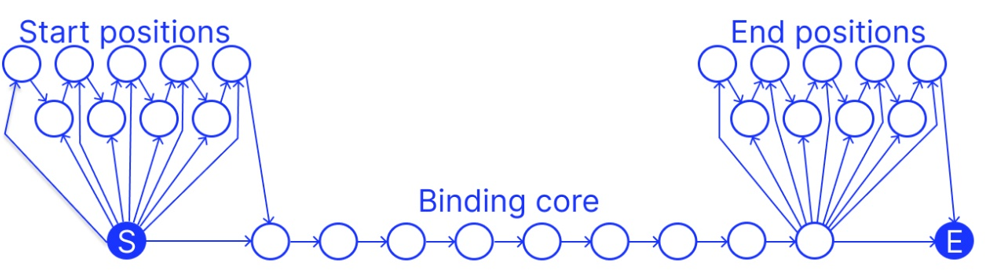

cycle_chain = True corresponds to the states in the start and end positions of the model architecture instead of simple cycle , cycle_chain_length - the number of them 

In [63]:
model_training_params = hmm_params.model_training_params
model_training_params.num_runs = 2
hmm_params.model_training_params.cycle_chain = True
hmm_params.model_training_params.cycle_chain_length = 9

# Data preparing

In [64]:
per_allele_per_kfold_per_length_binders_train, \
per_allele_per_kfold_per_length_binders_test, additional_data = get_train_test_data(hmm_params)

per_allele_per_kfold_per_length_non_binders_train, \
per_allele_per_kfold_per_length_non_binders_test, additional_data = get_train_test_data(hmm_params, "nonbinders")


PARSED_ALLELES = list(per_allele_per_kfold_per_length_binders_train.keys())
PARSED_ALLELES_NB = list(per_allele_per_kfold_per_length_non_binders_train.keys())

print(sorted(PARSED_ALLELES))
print(sorted(PARSED_ALLELES_NB))

Will read files from the folder C:\Projects\grandmaster\notebooks\alleles_data\simple_model_enrichment\per_length_per_kfold_split
Will read files from the folder C:\Projects\grandmaster\notebooks\alleles_data\simple_model_enrichment\per_length_per_kfold_split
['HLA-DRB1*03:01', 'HLA-DRB1*07:01', 'HLA-DRB1*10:01', 'HLA-DRB1*11:01', 'HLA-DRB1*12:01', 'HLA-DRB1*13:03', 'HLA-DRB1*15:01', 'HLA-DRB3*01:01', 'HLA-DRB3*02:02', 'HLA-DRB4*01:01']
['HLA-DRB1*03:01', 'HLA-DRB1*07:01', 'HLA-DRB1*10:01', 'HLA-DRB1*11:01', 'HLA-DRB1*12:01', 'HLA-DRB1*13:03', 'HLA-DRB1*15:01', 'HLA-DRB3*01:01', 'HLA-DRB3*02:02', 'HLA-DRB4*01:01']


For example of working with one allele let's take HLA-DRB1*03:01

In [65]:
model_training_params.lengths_to_use = [12, 13, 14, 15, 16, 17, 18, 19, 20]
df = additional_data[0][list(additional_data[0].keys())[0]]
[additional_data[0][key] for key in list(additional_data[0].keys())[:3]]
current_mix = ['HLA-DRB1*03:01']
model_training_params: training_parameters.ModelTrainingParams = hmm_params.model_training_params
model_training_params.alleles_to_use = [ item for item in current_mix]

#model_training_params.alleles_to_use = [ item for item in PARSED_ALLELES if item in [current_mix]]
t = remove_unused_lengths(per_allele_per_kfold_per_length_binders_train, experiment_params=hmm_params)

In [66]:
per_allele_per_kfold_per_length_binders_train = remove_unused_lengths(per_allele_per_kfold_per_length_binders_train, experiment_params=hmm_params)
per_allele_per_kfold_per_length_binders_test = remove_unused_lengths(per_allele_per_kfold_per_length_binders_test,experiment_params=hmm_params)

# transform to properties if needed and join multiple alleles
train_data_b, test_data_b, NEW_ALLELES, \
old_train_data_b, old_test_data_b, OLD_ALLELES = transform_data_to_properties_and_join_alleles(
    per_allele_per_kfold_per_length_binders_train,
    per_allele_per_kfold_per_length_binders_test,
    hmm_params.model_training_params
)
# Calculate weights for the training data based on peptide couns/lengths for unmerged data
train_data_weigths_b = calculate_weights_based_on_length_counts(old_train_data_b, experiment_params=hmm_params)

HLA-DRB1*03:01
Length 12: HLA-DRB1*03:01 - 135 
Length 13: HLA-DRB1*03:01 - 1555 
Length 14: HLA-DRB1*03:01 - 508 
Length 15: HLA-DRB1*03:01 - 1240 
Length 16: HLA-DRB1*03:01 - 794 
Length 17: HLA-DRB1*03:01 - 651 
Length 18: HLA-DRB1*03:01 - 460 
Length 19: HLA-DRB1*03:01 - 282 
Length 20: HLA-DRB1*03:01 - 408 


In [67]:
per_allele_per_kfold_per_length_non_binders_train = remove_unused_lengths(per_allele_per_kfold_per_length_non_binders_train, experiment_params=hmm_params)
per_allele_per_kfold_per_length_non_binders_test = remove_unused_lengths(per_allele_per_kfold_per_length_non_binders_test,experiment_params=hmm_params)

# transform to properties if needed and join multiple alleles
train_data_nb, test_data_nb, NEW_ALLELES, \
old_train_data_nb, old_test_data_nb, OLD_ALLELES = transform_data_to_properties_and_join_alleles(
    per_allele_per_kfold_per_length_non_binders_train,
    per_allele_per_kfold_per_length_non_binders_test,
    hmm_params.model_training_params
)
# Calculate weights for the training data based on peptide couns/lengths for unmerged data
train_data_weigths_nb = calculate_weights_based_on_length_counts(old_train_data_nb, experiment_params=hmm_params)

HLA-DRB1*03:01
Length 12: HLA-DRB1*03:01 - 63 
Length 13: HLA-DRB1*03:01 - 61656 
Length 14: HLA-DRB1*03:01 - 120 
Length 15: HLA-DRB1*03:01 - 1794 
Length 16: HLA-DRB1*03:01 - 113 
Length 17: HLA-DRB1*03:01 - 75 
Length 18: HLA-DRB1*03:01 - 68 
Length 19: HLA-DRB1*03:01 - 50 
Length 20: HLA-DRB1*03:01 - 505 


In [68]:
train_data_b_DRB1_03_01 = train_data_b['HLA-DRB1*03:01'][0]

# Prepare models

In [69]:
import random

random.seed(10)

from hmm_logic_methods import train_model_prepared,  \
    train_model_batched, save_model, \
    add_more_states_and_reset_transitions, \
    build_model_based_on_params, \
    prepare_multiple_models, train_multiple_models, \
reorder_models_by_score_and_flatten_to_by_name_list, hierarchically_train_splited_models, load_model
from hmm_visualization_methods import *

Binders

In [70]:
models_for_runs_b = make_models_for_runs('HLA-DRB1*03:01', hmm_params)

In [71]:
train_data_b_DRB1_03_01 = train_data_b['HLA-DRB1*03:01'][0]
test_data_b_DRB1_03_01 = test_data_b['HLA-DRB1*03:01'][0]
train_data_weights_b_DRB1_03_01 = train_data_weigths_b['HLA-DRB1*03:01'][0]

In [72]:
hmm_params.experiment_result_data_path = 'C:\\Projects\\grandmaster\\notebooks\\MHC_predictor\\experiments\\core_identification_simple_model_enrichment\\experiment_results\\no_allele_no_split'

In [73]:
path_to_save_runs_b = hmm_params.experiment_result_data_path + '\\binders\\'

In [74]:
result_models_b_only_runs, h_runs = train_models_for_runs(models_for_runs_b, train_data_b_DRB1_03_01, test_data_b_DRB1_03_01, train_data_weights_b_DRB1_03_01, model_training_params, path_to_save_runs_b)

Run root[0000] Run root[0001]  


In [75]:
path_to_save_runs_reordered_b = path_to_save_runs_b + '\\reordered\\'

In [76]:
sorted_models_per_runs, sorted_hist_per_runs, mapping_dict = reorder_per_run_models_by_score(result_models_b_only_runs, h_runs, path_to_save_runs_reordered_b)

Run run[0000] Run run[0001] 

Non-binders

In [77]:
train_data_nb_DRB1_03_01 = train_data_nb['HLA-DRB1*03:01'][0]
test_data_nb_DRB1_03_01 = test_data_nb['HLA-DRB1*03:01'][0]
train_data_weights_nb_DRB1_03_01 = train_data_weigths_nb['HLA-DRB1*03:01'][0]

In [78]:
models_for_runs_nb = make_models_for_runs('HLA-DRB1*03:01', hmm_params)

In [79]:
path_to_save_runs_nb = hmm_params.experiment_result_data_path + '\\nonbinders\\'

In [80]:
result_models_nb_only_runs, h_runs_nb = train_models_for_runs(models_for_runs_nb, train_data_nb_DRB1_03_01, test_data_nb_DRB1_03_01, train_data_weights_nb_DRB1_03_01, model_training_params, path_to_save_runs_nb)

Run root[0000] Run root[0001]  


In [81]:
path_to_save_runs_reordered_nb = path_to_save_runs_nb + '\\reordered\\'

In [82]:
sorted_models_per_runs_nb, sorted_hist_per_runs_nb, mapping_dict_nb = reorder_per_run_models_by_score(result_models_nb_only_runs, h_runs_nb, path_to_save_runs_reordered_nb)

Run run[0000] Run run[0001] 

# Visualisation

In [83]:
hmm_params.experiment_result_data_path = 'C:\\Projects\\grandmaster\\notebooks\\MHC_predictor\\experiments\\core_identification_simple_model_enrichment\\experiment_results\\no_allele_no_split'

In [84]:
save_visualizations_for_runs(sorted_models_per_runs, sorted_hist_per_runs, experiment_params=hmm_params, split_path = hmm_params.experiment_result_data_path +'/1_split')

# Visualization results 

Graph with model architecture and amino acids in each state

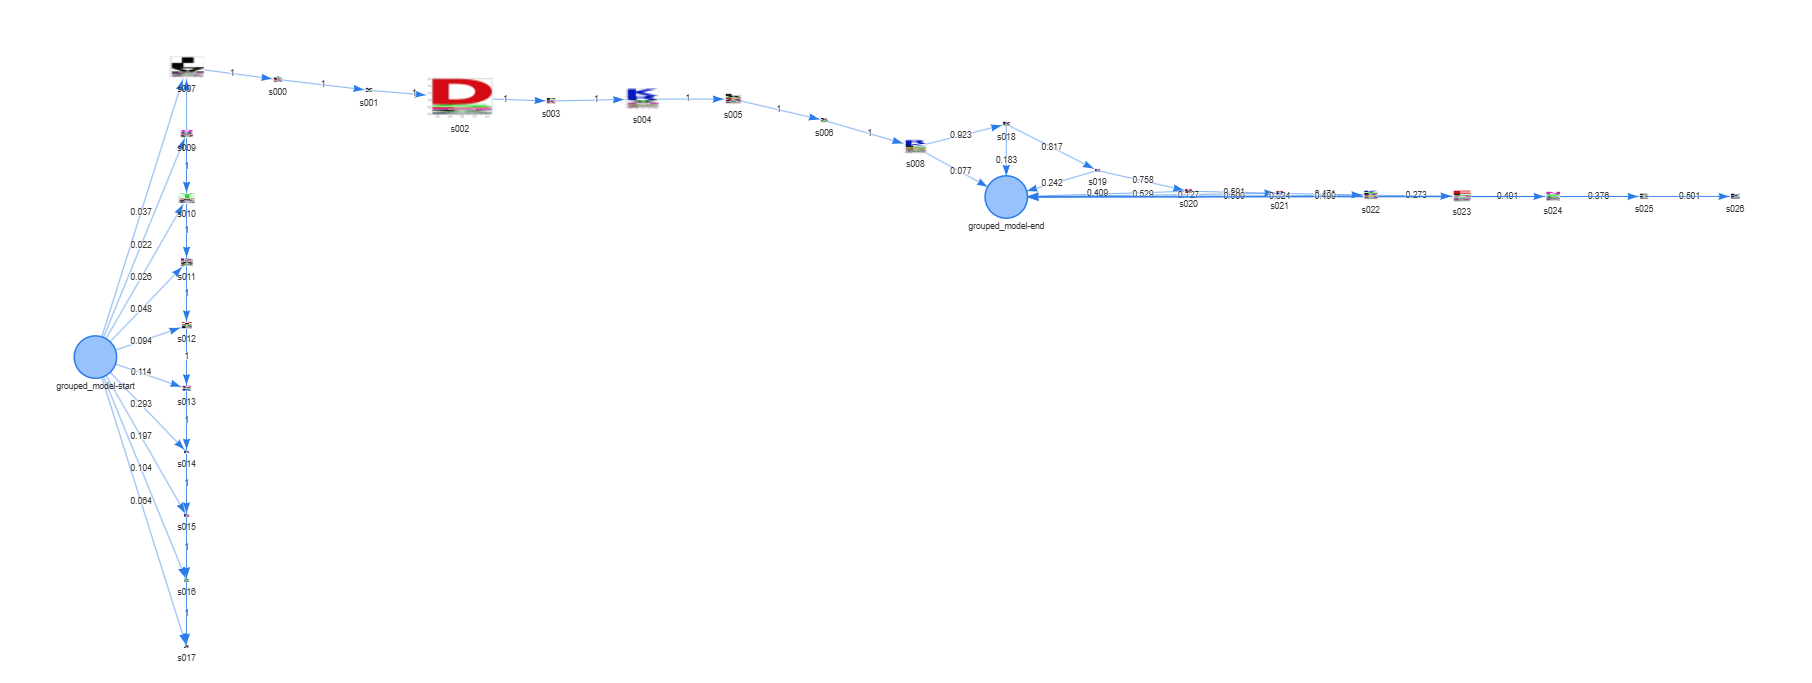

Learning curve

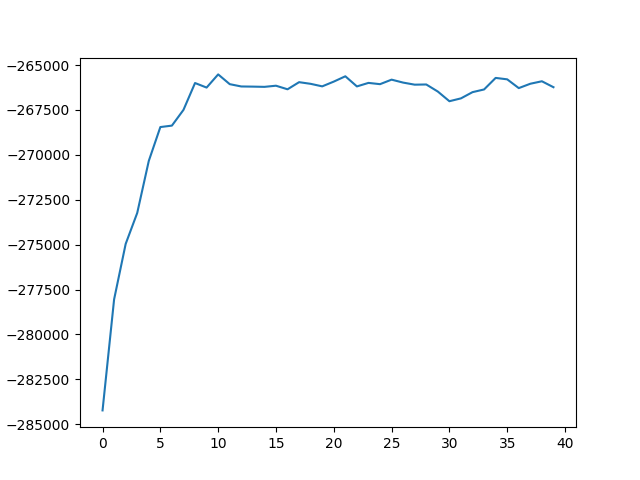